In [1]:
import multiprocessing as mp
import librosa
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

from audio import DMD, STDMD, autils

In [2]:
mp.cpu_count()

8

In [2]:
FRAME_LENGTH = 2048
HOP_LENGTH = 1024

y, sr = librosa.load('./data/lj_0.wav')
frames = librosa.util.frame(
    y, axis=0, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH
).astype(np.float32)
print(frames.shape)

print('max={}, min={}'.format(y.min(), y.max()))
display(Audio(y, rate=sr))

(179, 2048)
max=-0.340301513671875, min=0.411651611328125


#### Test on single frame

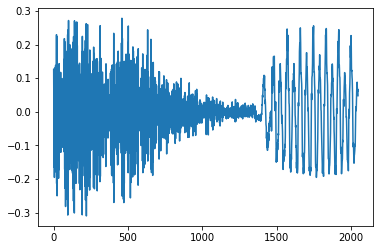

In [3]:
IDX = 80

frame = frames[IDX]
plt.plot(frame);
display(Audio(frame, rate=sr))

In [19]:
N_FREQS_TO_CAPTURE = 80
FL, HL = 3*N_FREQS_TO_CAPTURE, 1

subframes = librosa.util.frame(
    frame, axis=0, frame_length=FL, hop_length=HL
).astype(np.float32)
subframes.shape

(1809, 240)

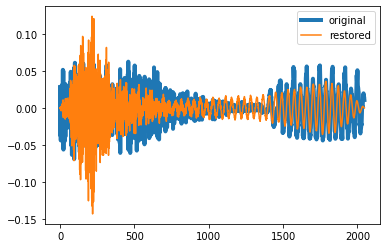

In [20]:
dmd = DMD(svd_rank=128, opt='projected', lag=1)
subframes_hat = dmd.fit_reconstruct(subframes.T)
frame_hat = autils.frames_to_wave(subframes_hat.real.T, hop_length=HL)
plt.plot(frame / np.linalg.norm(frame), label='original', linewidth=4)
plt.plot(frame_hat / np.linalg.norm(frame_hat), label='restored')
plt.legend()
display(Audio(frame_hat, rate=sr))

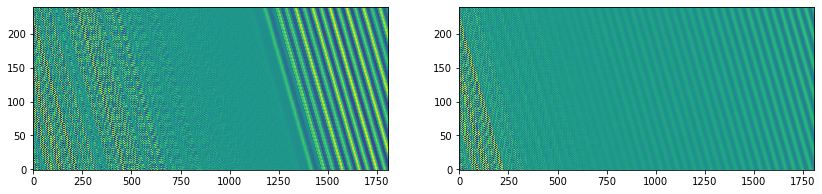

In [21]:
plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.imshow(subframes.real.T, aspect='auto', origin='bottom');
plt.subplot(1,2,2)
plt.imshow(subframes_hat.real, aspect='auto', origin='bottom');

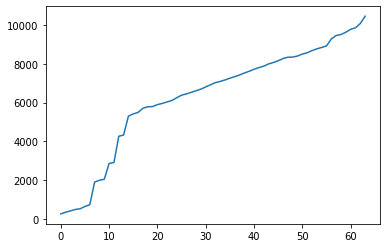

In [22]:
delta_t = HL / sr

freqs = np.log(dmd.eigvals).imag / (2 * np.pi * delta_t)
positive_mask = freqs > 0
freqs = freqs[positive_mask]
sorted_idx = np.argsort(freqs)
freqs = freqs[sorted_idx]
modes = dmd.modes[:, positive_mask][:, sorted_idx]
b = dmd.b[positive_mask][sorted_idx]
plt.plot(freqs);

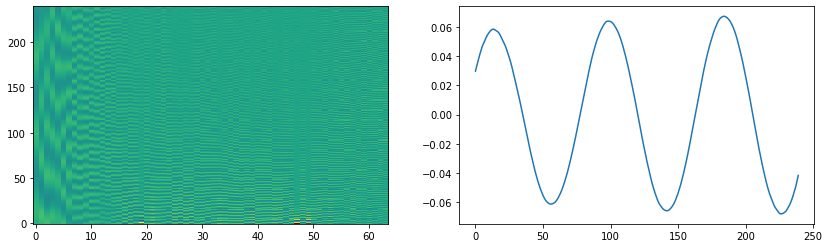

In [23]:
MODE_IDX = 0

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.imshow(modes.real, aspect='auto', origin='bottom')
plt.subplot(1,2,2)
plt.plot(modes.real[:, MODE_IDX]);

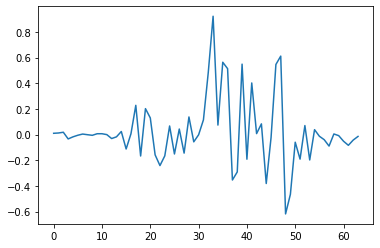

In [24]:
plt.plot(b.real);

#### Test on whole signal

In [146]:
class STFT(object):
    def __init__(self, frame_length=1024, hop_length=256):
        self.frame_length = frame_length
        self.hop_length = hop_length
    
    def transform(self, x):
        frames = librosa.util.frame(
            x, frame_length=self.frame_length,
            hop_length=self.hop_length
        ).astype(np.float32).T
        
        return np.array([np.log10(np.abs(np.fft.rfft(frame.real).real) + 1e-6)
                         for frame in frames])

In [147]:
stdmd = STDMD(
    frame_length=FRAME_LENGTH,
    hop_length=HOP_LENGTH,
    subframe_length=FL,
    subhop_length=HL,
    n_noise_modes=0,
    opt='projected',
    lag=1,
    sampling_rate=22050
)
dmdgram = stdmd.fit_transform(y)

100%|████████████████████████████████████| 179/179 [00:19<00:00,  8.18it/s]


In [148]:
dmdgram = np.array([list(ts)[:N_FREQS_TO_CAPTURE] + [0] * (N_FREQS_TO_CAPTURE - len(ts)) for ts in dmdgram])

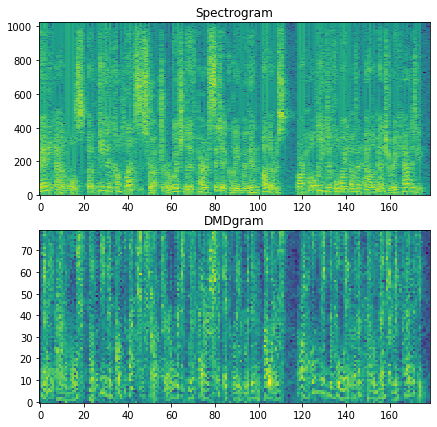

In [149]:
stft = STFT(frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)

plt.figure(figsize=(7, 7))
plt.subplot(2,1,1)
plt.title('Spectrogram')
plt.imshow(stft.transform(y).T, aspect='auto', origin='bottom')
plt.subplot(2,1,2)
plt.title('DMDgram')
plt.imshow(np.log(np.dmdgram.real.T + 1e-7), aspect='auto', origin='bottom');